# Análise Passagens de Avião Rio - Berlim

## Import e Pré-Processamento do Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
from keras import backend as K

In [3]:
df_2022 = pd.read_csv(r"C:\Users\lgrne\OneDrive\Documents\AULAS PUC BI\Projeto Final\csv_scrap\berlim_2022_v2.csv")
df_2023 = pd.read_csv(r"C:\Users\lgrne\OneDrive\Documents\AULAS PUC BI\Projeto Final\csv_scrap\berlim_2023_v2.csv")

dataframes = [df_2022,df_2023]

In [4]:
# Concatenando os dois csvs em um único dataset, e fazendo uma limpeza de colunas desnecessárias

df_final = pd.concat(dataframes)

In [5]:
df_final = df_final.reset_index()

df_final = df_final.drop("index", axis=1)

df_final = df_final.drop("Unnamed: 0", axis=1)

In [6]:
df_final

,Destino,Ida,Volta,Preco
0,Berlim,2022-07-01,2022-07-08,R$ 9.923
1,Berlim,2022-07-03,2022-07-10,R$ 8.888
2,Berlim,2022-07-06,2022-07-13,R$ 8.275
3,Berlim,2022-07-09,2022-07-16,R$ 9.867
4,Berlim,2022-07-12,2022-07-19,R$ 8.714
...,...,...,...,...
83,Berlim,2023-05-09,2023-05-16,R$ 3.682
84,Berlim,2023-05-12,2023-05-19,R$ 3.970
85,Berlim,2023-05-15,2023-05-22,R$ 3.970
86,Berlim,2023-05-18,2023-05-25,R$ 3.682


In [7]:
#Limpando a coluna de preço, e convertendo os valores de string para inteiro

for i in df_final.index:
    df_final.loc[i,'Preco'] = df_final.loc[i,'Preco'].replace("R$ ","")
    df_final.loc[i,'Preco'] = df_final.loc[i,'Preco'].replace(".","")
    
df_final['Preco'] = df_final['Preco'].astype(int)

In [8]:
#Criando um segundo dataset com as datas como index e o unico valor de preço 

df_final2 = df_final
df_final2.index = df_final['Ida']
df_final2 = df_final.drop(columns=['Destino', 'Volta','Ida'])

In [9]:
df_final2

,Preco
Ida,
2022-07-01,9923
2022-07-03,8888
2022-07-06,8275
2022-07-09,9867
2022-07-12,8714
...,...
2023-05-09,3682
2023-05-12,3970
2023-05-15,3970


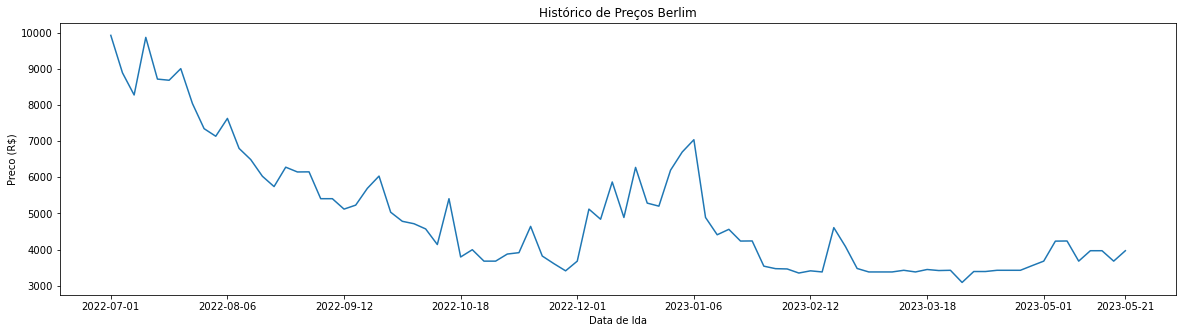

In [10]:
#Plot final do dataset

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(df_final2['Preco'])
plt.xlabel("Data de Ida")
plt.ylabel("Preco (R$)")
plt.title("Histórico de Preços Berlim")
plt.xticks([0,10,20,30,40,50,60,70,80,87]) 
plt.show()

## Separação em treino e teste e Normalização

In [11]:
# É necessário fazer esse window antes para garantir que está mantendo o vínculo temporal de evolução dos dados
window = 3
dataSize = len(df_final2['Preco'])
X = []
y = []
for i in range(window, dataSize):
    X.append(df_final2.iloc[i-window:i, 0])
    y.append(df_final2.iloc[i, 0])
X, y = np.array(X), np.array(y)

In [12]:
X.shape,y.shape

((85, 3), (85,))

In [13]:
# Separando entre treino e teste o dataset completo (X,y) -> (X_train, y_train e X_test, y_test)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# Normalização

from sklearn.preprocessing import MinMaxScaler

sc_x = MinMaxScaler(feature_range = (0, 1))
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

sc_y = MinMaxScaler(feature_range = (0, 1))
y_train = sc_y.fit_transform(y_train.reshape(-1,1))
y_test = sc_y.transform(y_test.reshape(-1,1))

### LSTM

In [15]:
# Reshape para entrada nas redes do keras

X_train_reshape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
X_train_reshape.shape

(68, 3, 1)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_reshape.shape[1], 1)))
 
# Adicionar a segunda camada LSTM
regressor.add(LSTM(units = 100, return_sequences = False))

# camada de saída
regressor.add(Dense(units = 1, activation=None))
 
# Compilar a rede
lr = 0.001
lr_adam = tf.keras.optimizers.Adam(learning_rate=lr)
regressor.compile(optimizer = lr_adam, loss = 'mse', metrics='mae')

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Parâmetros de callbacks

monitor = 'val_loss'
lr_reduce = ReduceLROnPlateau(monitor=monitor, factor=0.6, min_delta=0.0001, patience=4, verbose=1)
early = EarlyStopping(monitor=monitor, mode="min", patience=15)
kwargs = {}
kwargs['epochs'] = 250
kwargs['batch_size'] = 50
kwargs['shuffle'] = True
kwargs['validation_data'] = (X_test_reshape, y_test)
kwargs['verbose'] = 1
kwargs['callbacks'] = [early, lr_reduce]

history = regressor.fit(X_train_reshape, y_train, **kwargs)

Epoch 1/250
2/2 [==============================] - 3s 741ms/step - loss: 0.1053 - mae: 0.2344 - val_loss: 0.1062 - val_mae: 0.2584 - lr: 0.0010
Epoch 2/250
2/2 [==============================] - 0s 23ms/step - loss: 0.0857 - mae: 0.2015 - val_loss: 0.0822 - val_mae: 0.2191 - lr: 0.0010
Epoch 3/250
2/2 [==============================] - 0s 23ms/step - loss: 0.0662 - mae: 0.1685 - val_loss: 0.0598 - val_mae: 0.1815 - lr: 0.0010
Epoch 4/250
2/2 [==============================] - 0s 23ms/step - loss: 0.0505 - mae: 0.1470 - val_loss: 0.0397 - val_mae: 0.1457 - lr: 0.0010
Epoch 5/250
2/2 [==============================] - 0s 23ms/step - loss: 0.0354 - mae: 0.1295 - val_loss: 0.0241 - val_mae: 0.1144 - lr: 0.0010
Epoch 6/250
2/2 [==============================] - 0s 23ms/step - loss: 0.0240 - mae: 0.1206 - val_loss: 0.0153 - val_mae: 0.1006 - lr: 0.0010
Epoch 7/250
2/2 [==============================] - 0s 25ms/step - loss: 0.0194 - mae: 0.1220 - val_loss: 0.0150 - val_mae: 0.1063 - lr: 0.001

Epoch 50/250
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0682
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.6796160707599483e-05.
2/2 [==============================] - 0s 23ms/step - loss: 0.0090 - mae: 0.0696 - val_loss: 0.0065 - val_mae: 0.0608 - lr: 2.7994e-05
Epoch 51/250
2/2 [==============================] - 0s 21ms/step - loss: 0.0090 - mae: 0.0696 - val_loss: 0.0065 - val_mae: 0.0608 - lr: 1.6796e-05
Epoch 52/250
2/2 [==============================] - 0s 22ms/step - loss: 0.0090 - mae: 0.0696 - val_loss: 0.0065 - val_mae: 0.0608 - lr: 1.6796e-05
Epoch 53/250
2/2 [==============================] - 0s 22ms/step - loss: 0.0090 - mae: 0.0696 - val_loss: 0.0065 - val_mae: 0.0608 - lr: 1.6796e-05
Epoch 54/250
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0680
Epoch 54: ReduceLROnPlateau reducing learning rate to 1.007769642455969e-05.
2/2 [==============================] - 0s 22ms/step - loss: 0.0090 - mae: 0.0696 - val_l

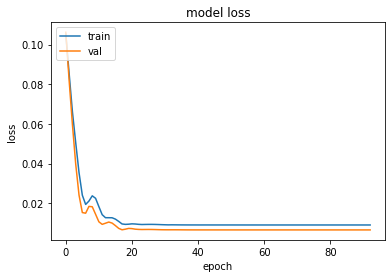

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Inferência

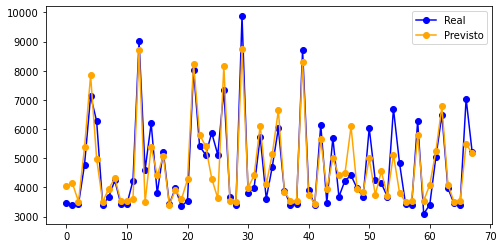

In [21]:
# inferencia sobre a base X_train

y_train_pred = regressor.predict(X_train_reshape)

plt.figure(figsize=(8,4))
plt.plot(sc_y.inverse_transform(y_train.reshape(-1,1)), color='b', label='Real', marker='o')
plt.plot(sc_y.inverse_transform(y_train_pred.reshape(-1,1)), color='orange', label='Previsto', marker='o')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE: " + str(mean_squared_error(sc_y.inverse_transform(y_train.reshape(-1,1)), sc_y.inverse_transform(y_train_pred.reshape(-1,1)))))
print("MAE: " + str(mean_absolute_error(sc_y.inverse_transform(y_train.reshape(-1,1)), sc_y.inverse_transform(y_train_pred.reshape(-1,1)))))
print("R2: " + str(r2_score(sc_y.inverse_transform(y_train.reshape(-1,1)), sc_y.inverse_transform(y_train_pred.reshape(-1,1)))))

MSE: 414155.97816319333
MAE: 473.03372012867646
R2: 0.8262107262427182


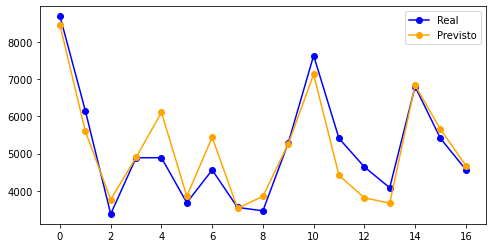

In [23]:
# inferencia sobre a base X_test

y_test_pred = regressor.predict(X_test_reshape)

plt.figure(figsize=(8,4))
plt.plot(sc_y.inverse_transform(y_test.reshape(-1,1)), color='b', label='Real', marker='o')
plt.plot(sc_y.inverse_transform(y_test_pred.reshape(-1,1)), color='orange', label='Previsto', marker='o')
plt.legend()
plt.show()

In [24]:
print("MSE: " + str(mean_squared_error(sc_y.inverse_transform(y_test.reshape(-1,1)), sc_y.inverse_transform(y_test_pred.reshape(-1,1)))))
print("MAE: " + str(mean_absolute_error(sc_y.inverse_transform(y_test.reshape(-1,1)), sc_y.inverse_transform(y_test_pred.reshape(-1,1)))))
print("R2: " + str(r2_score(sc_y.inverse_transform(y_test.reshape(-1,1)), sc_y.inverse_transform(y_test_pred.reshape(-1,1)))))

MSE: 299890.2775145663
MAE: 412.09827378216914
R2: 0.8556529793427932
